In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

pd.options.display.max_columns = None
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df = pd.read_csv("datalog_ilapak10.csv", index_col=0, parse_dates=True)
df.head()

,suhu_sealing_vertikal_bawah,suhu_sealing_vertikal_atas,suhu_sealing_horizontal_depan,suhu_sealing_horizontal_belakang,jaws_position,knife_position,pump_position_stop,doser_drive_enable,sealing_enable,machine_alarm,downtime_sec,output_time_sec,total_time_sec
times,,,,,,,,,,,,,
2024-01-30 15:52:04,104.2,104.3,41.6,108.5,0,0,0,0,0,0,176.0,0.0,177.0
2024-01-30 15:57:04,204.0,204.0,88.7,203.5,0,0,0,0,0,0,477.0,0.0,477.0
2024-01-30 16:02:04,207.9,207.9,110.8,207.8,0,0,0,0,0,0,720.0,0.0,777.0
2024-01-30 16:07:04,209.0,209.0,123.5,209.1,0,0,0,0,0,0,720.0,0.0,1077.0
2024-01-30 16:12:04,209.5,209.5,136.0,209.5,0,0,0,0,0,0,720.0,0.0,1377.0


# I. Exploratory Data Analysis

## I.a Outliers Analysis

### Numeric Columns

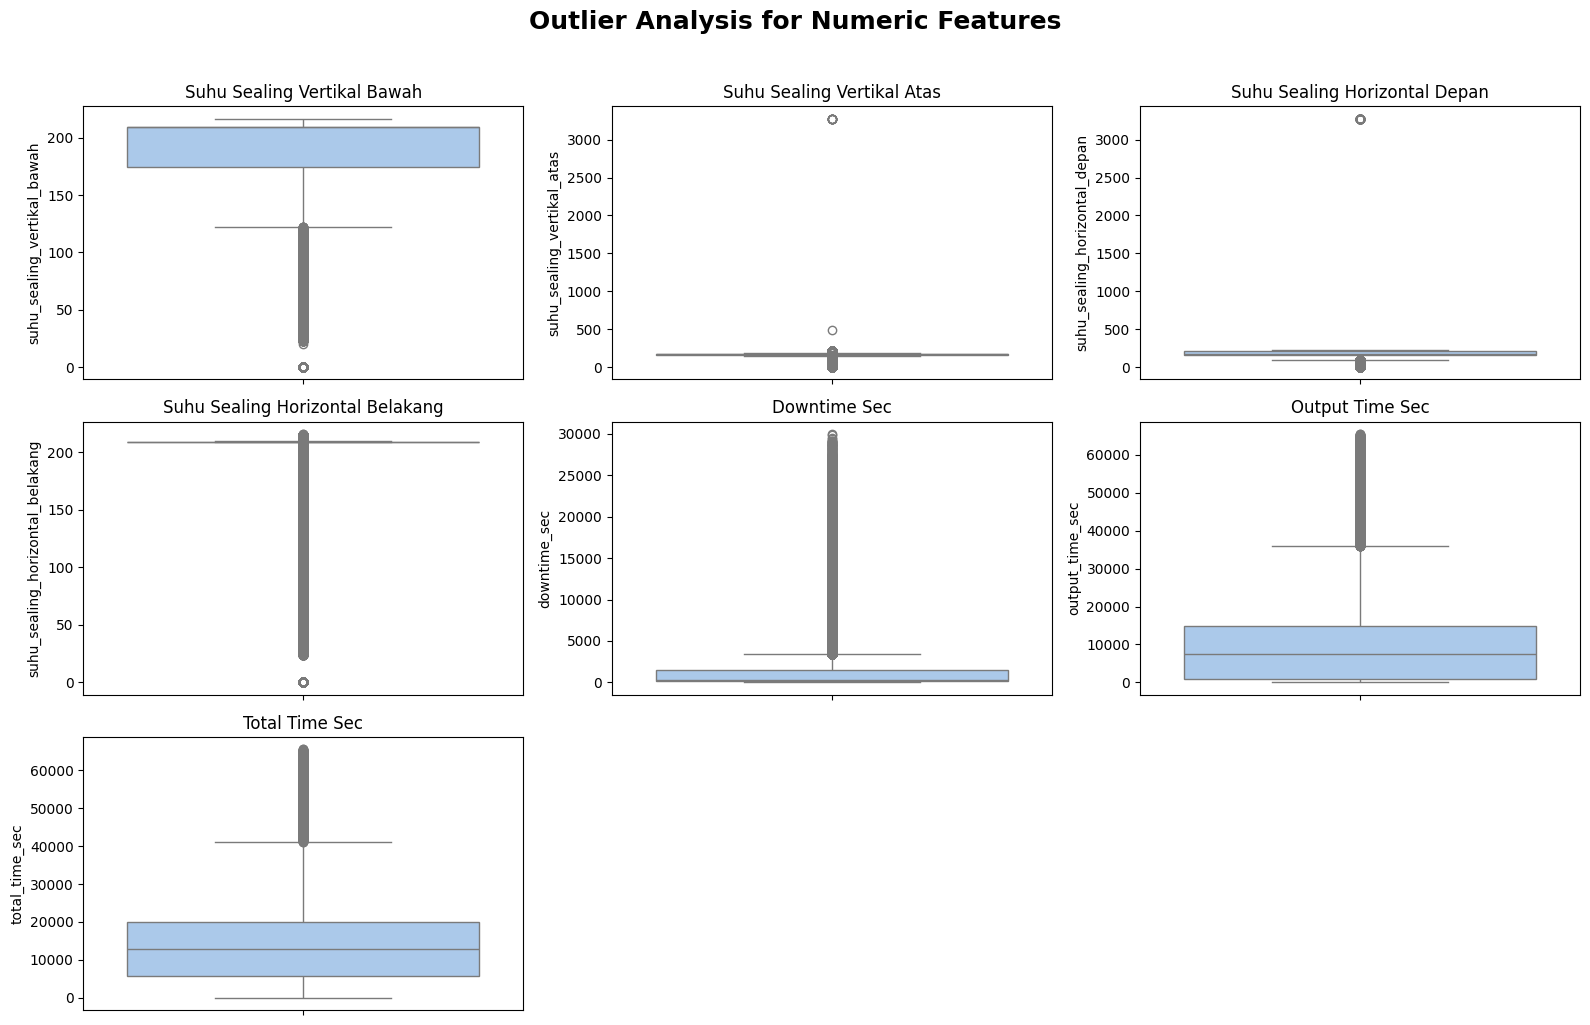

In [3]:
numeric_cols = [
    'suhu_sealing_vertikal_bawah', 
    'suhu_sealing_vertikal_atas',
    'suhu_sealing_horizontal_depan',
    'suhu_sealing_horizontal_belakang',
    'downtime_sec',
    'output_time_sec',
    'total_time_sec'
]

plt.figure(figsize=(16, 10))
plt.suptitle("Outlier Analysis for Numeric Features", fontsize=18, weight='bold', y=1.02)

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col], color=sns.color_palette("pastel")[0])
    plt.title(col.replace('_', ' ').title(), fontsize=12)

plt.tight_layout()
plt.show()

In [4]:
df_cleaned = df.copy()
print(f"Shape before outlier removal: {df_cleaned.shape}")

for col in numeric_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

print(f"Shape after outlier removal: {df_cleaned.shape}")
print(f"Percentage of data removed: {1 - df_cleaned.shape[0] / df.shape[0]:.2%}")

Shape before outlier removal: (187803, 13)
Shape after outlier removal: (93585, 13)
Percentage of data removed: 50.17%


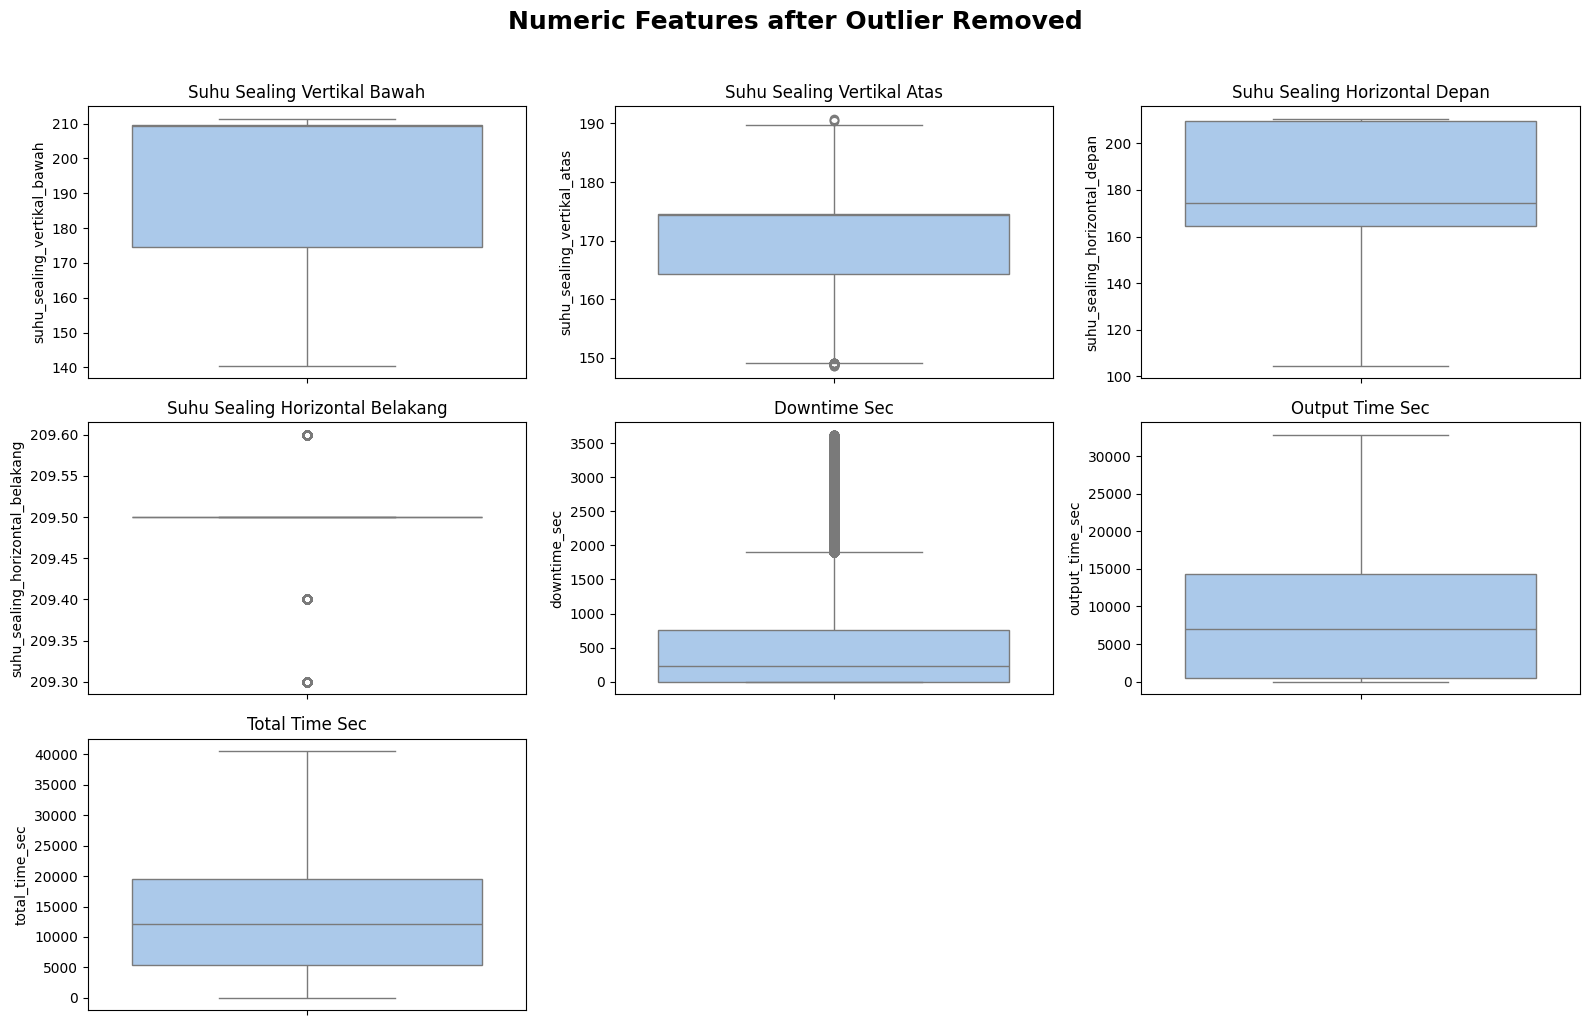

In [5]:
plt.figure(figsize=(16, 10))
plt.suptitle("Numeric Features after Outlier Removed", fontsize=18, weight='bold', y=1.02)

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df_cleaned[col], color=sns.color_palette("pastel")[0])
    plt.title(col.replace('_', ' ').title(), fontsize=12)

plt.tight_layout()
plt.show()

### Distribution of Binary Columns

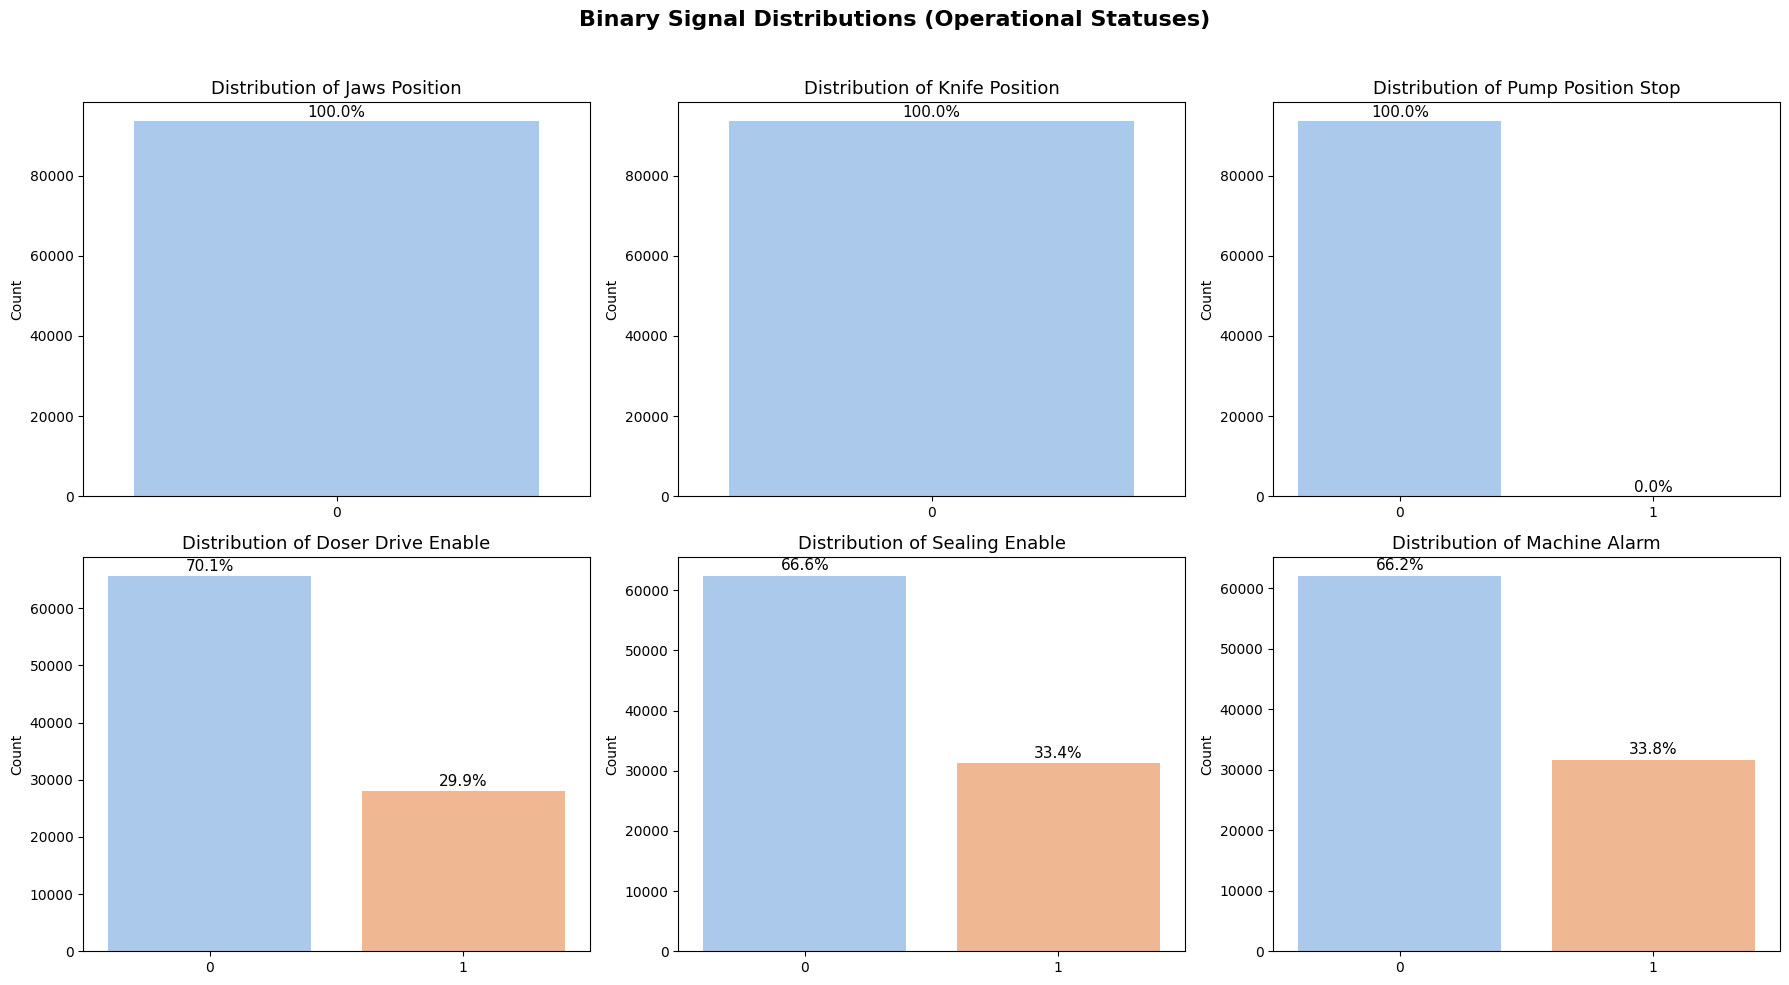

In [6]:
binary_cols = [
    'jaws_position', 'knife_position', 'pump_position_stop',
    'doser_drive_enable', 'sealing_enable', 'machine_alarm'
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(binary_cols):
    ax = axes[i]
    sns.countplot(data=df_cleaned, x=col, ax=ax, palette='pastel')

    total = len(df_cleaned)
    for p in ax.patches:
        count = p.get_height()
        percentage = f'{100 * count / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = count
        ax.text(x, y + total * 0.01, percentage, ha='center', fontsize=11)

    ax.set_title(f'Distribution of {col.replace("_", " ").title()}', fontsize=13)
    ax.set_xlabel('')
    ax.set_ylabel('Count')

plt.suptitle('Binary Signal Distributions (Operational Statuses)', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Correlation Matrix

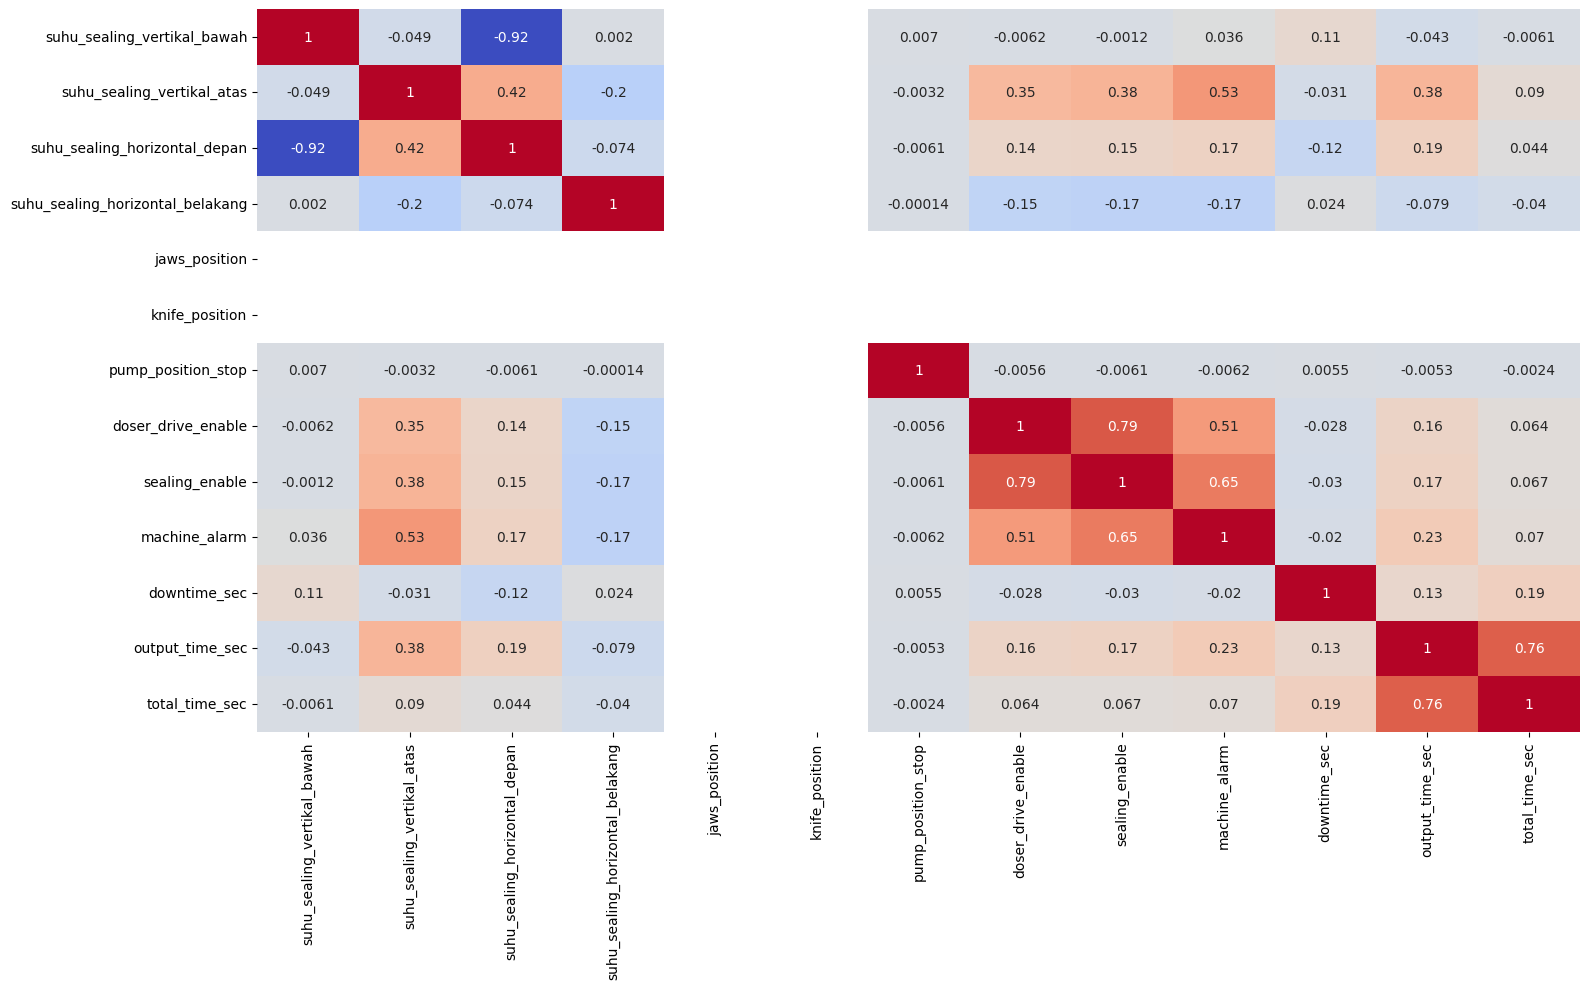

In [7]:
plt.figure(figsize=(16, 10))
sns.heatmap(df_cleaned.corr(), annot=True, cmap="coolwarm", cbar=False)
plt.tight_layout()

## I.b Trend Analysis of Sealing Temperature Columns During Abnormal Machine States

**Main Objective:**

Melihat bagaimana kolom-kolom suhu sealing (misalnya: suhu_sealing_vertikal_bawah, suhu_sealing_horizontal_belakang, dll.) berubah atau mengalami tren tertentu ketika mesin mengalami alarm atau kondisi abnormal.

**Why is Metter:**
1. Stabilitas suhu = kunci keberhasilan sealing:
    - proses sealing di mesin kemasan membutuhkan suhu yang konsisten dan optimal.
    - Fluktuasi suhu bisa menyebabkan hasil sealing tidak sempurna (misalnya bocor).

2. Memahami akar masalah anomali (root cause analysis):

    Dengan membandingkan tren suhu saat alarm aktif vs normal, kita bisa mencari tahu apakah ada hubungan suhu tidak stabil dengan munculnya alarm.

3. Membantu pemilihan fitur untuk model ML:

    Jika tren suhu terbukti berperan penting dalam munculnya anomali, maka kolom-kolom tersebut bisa menjadi fitur utama dalam model deteksi anomali (unsupervised) atau prediksi alarm.

4. Prediksi dini alarm:

    Jika ditemukan pola suhu tertentu yang selalu muncul beberapa saat sebelum alarm aktif, kita bisa memanfaatkannya untuk memprediksi alarm sebelum benar-benar terjadi (early warning system).


In [16]:
# Function helper
def get_abnormal_segments(mask):
    segments = []
    start = None
    for i, val in enumerate(mask):
        if val and start is None:
            start = i
        elif not val and start is not None:
            segments.append((start, i - 1))
            start = None
    if start is not None:
        segments.append((start, len(mask) - 1))
    return segments

def plot_temperature(df: pd.DataFrame, period: str = "all_time", with_segments: bool = False):
    temp_cols = [
        'suhu_sealing_vertikal_bawah', 'suhu_sealing_vertikal_atas',
        'suhu_sealing_horizontal_depan', 'suhu_sealing_horizontal_belakang'
    ]

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index of dataframe must be a DatatimeIndex")

    now = df.index.max()
    if period == "last_day":
        df_period = df[df.index >= now - pd.Timedelta(days=1)]
    elif period == "last_week":
        df_period = df[df.index >= now - pd.Timedelta(days=7)]
    elif period == "last_month":
        df_period = df[df.index >= now - pd.Timedelta(days=30)]
    elif period == "last_year":
        df_period = df[df.index >= now - pd.Timedelta(days=365)]
    else:
        df_period = df

    _, axes = plt.subplots(len(temp_cols), 1, figsize=(18, 10), sharex=True)
    for i, col in enumerate(temp_cols):
        sns.lineplot(data=df_period, x=df_period.index, y=col, ax=axes[i], palette="pastel")
        axes[i].set_title(f"{col.replace('_', ' ').title()}", fontsize=12, loc="left")
        axes[i].set_ylabel("Temp (°C)")
        axes[i].set_ylim(100, 300) 
        axes[i].grid(True)

        if with_segments:
            abnormal_mask = (
                (df_period["machine_alarm"] == 1) &
                (df_period["sealing_enable"] == 0) &
                (df_period["doser_drive_enable"] == 0)
            )
            segments = get_abnormal_segments(abnormal_mask.values)
            for start, end in segments:
                axes[i].axvspan(df_period.index[start], df_period.index[end], color='red', alpha=0.3)

    axes[-1].set_xlabel("Timestamp")
    highlight_text = "with Machine Alarm Highlighted" if with_segments else ""
    plt.suptitle(f"Sealing Temperature Trends {highlight_text} ({period.replace('_', ' ').title()})",
                 fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### All Time

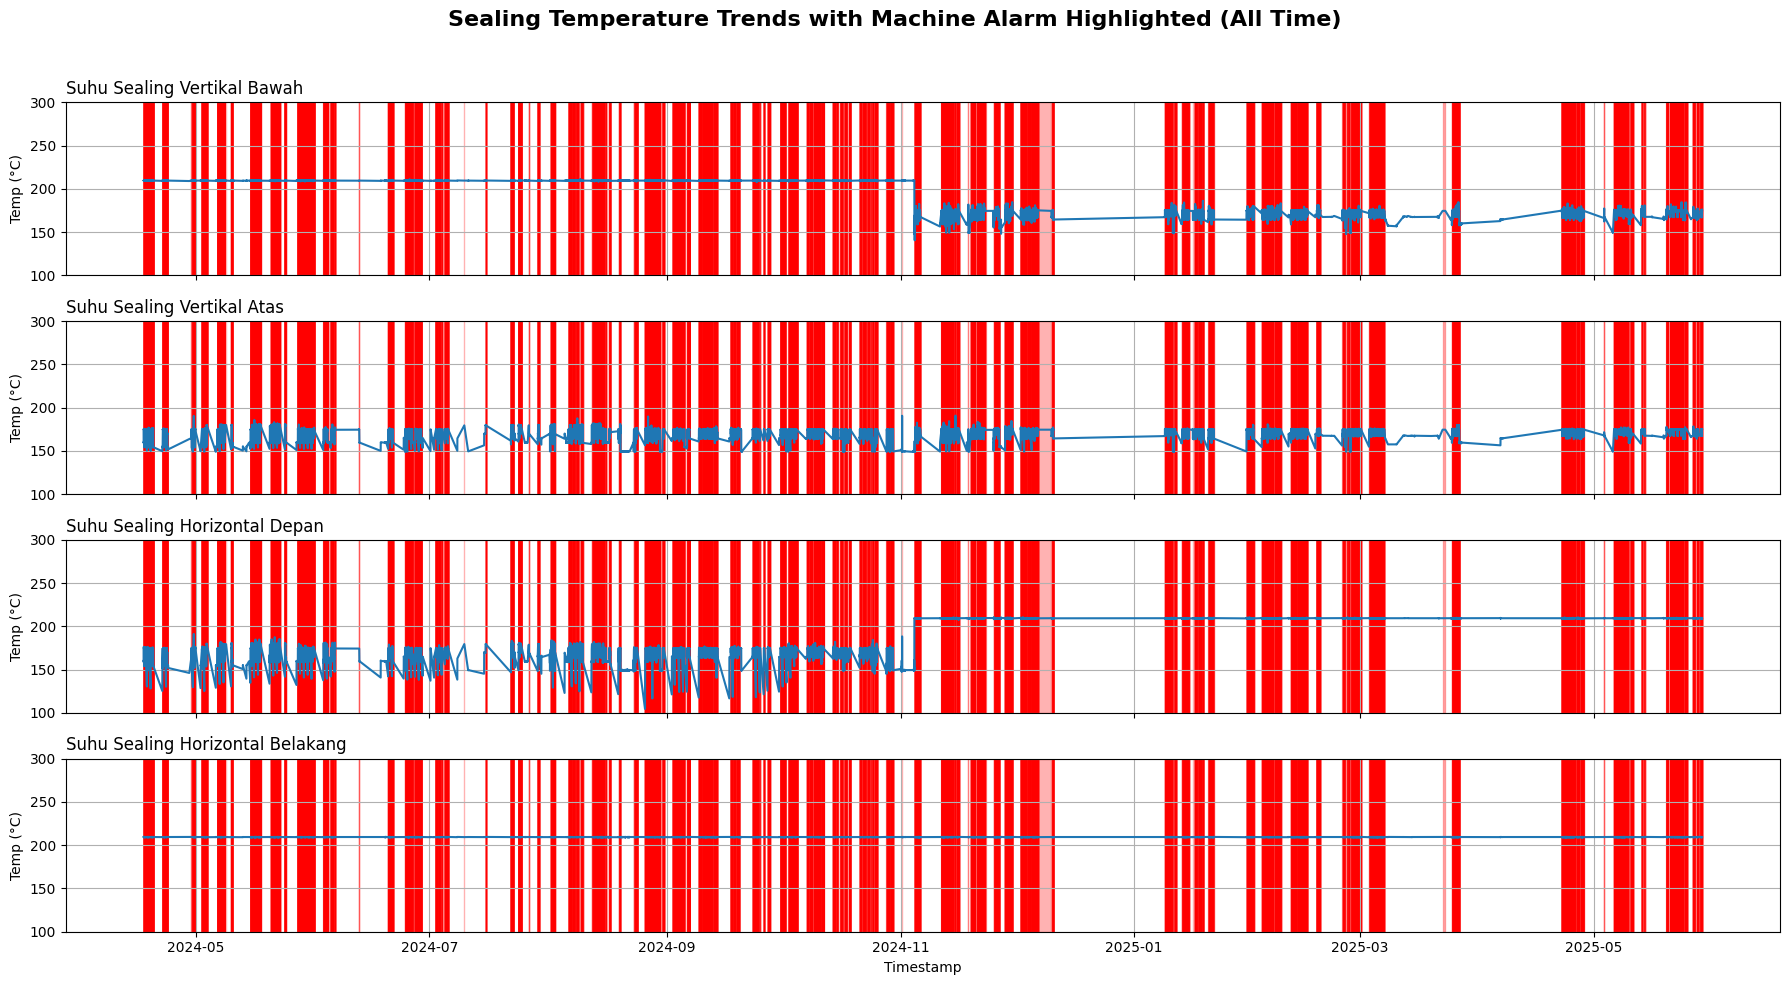

In [9]:
plot_temperature(df_cleaned, with_segments=True)

### Last Month

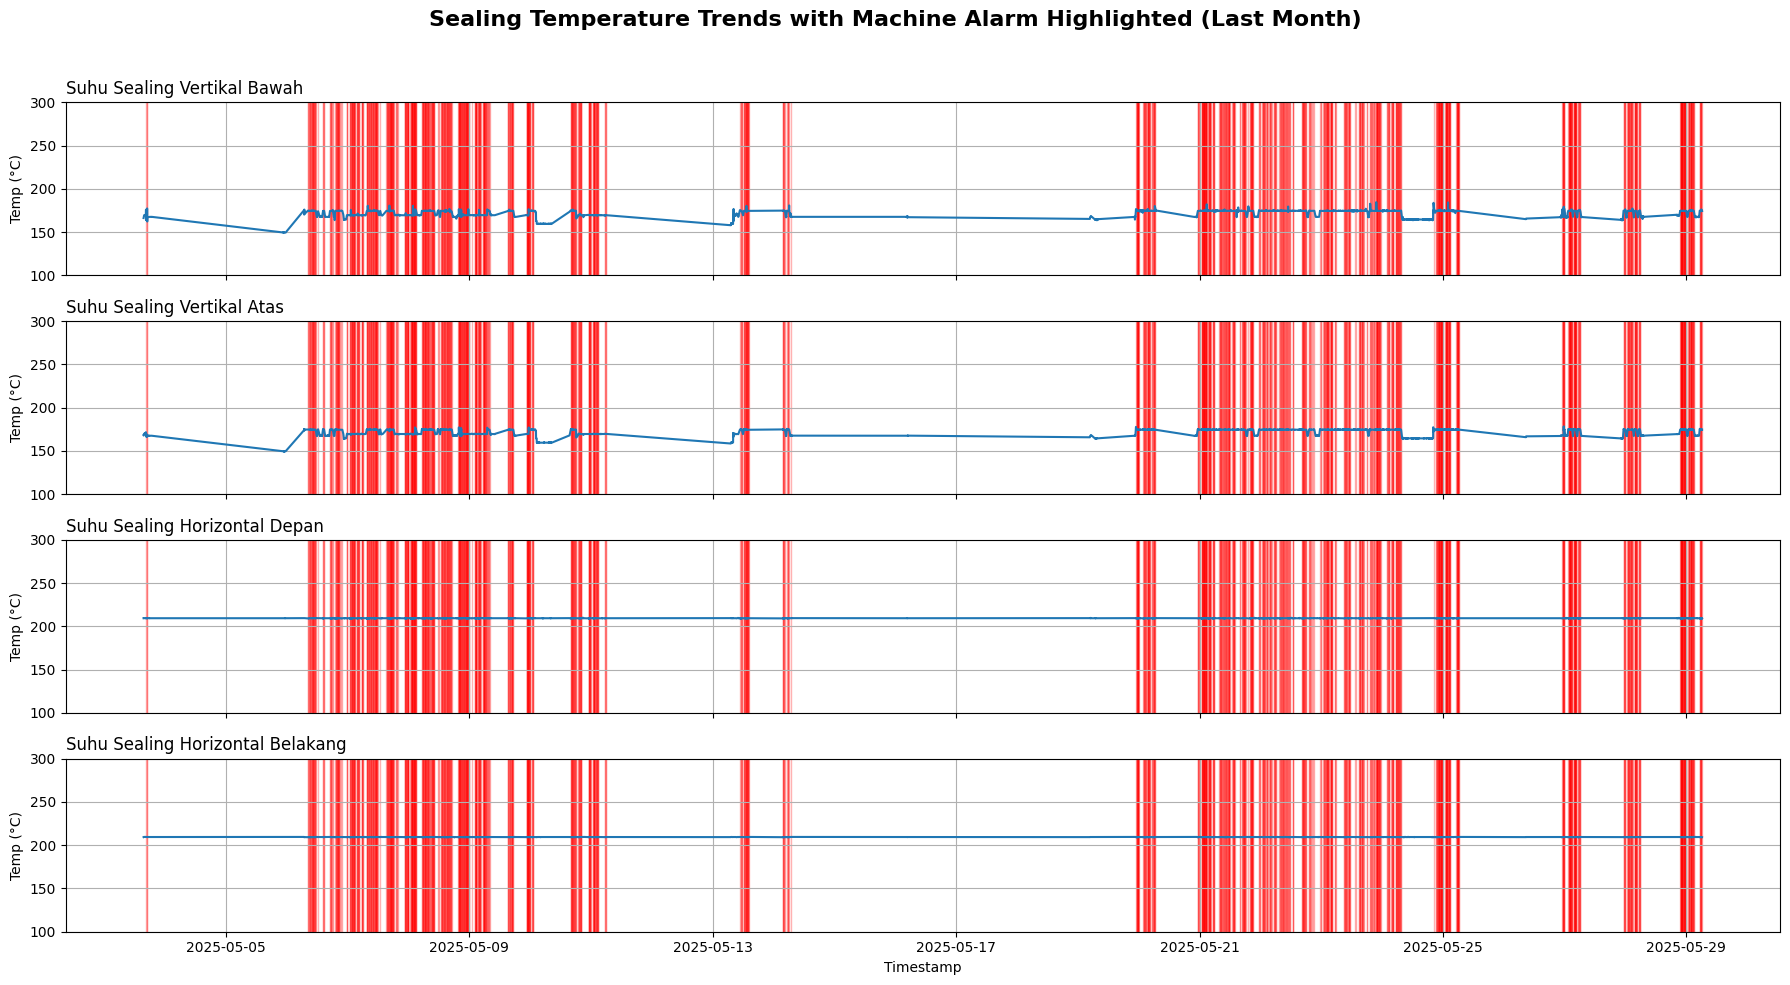

In [10]:
plot_temperature(df_cleaned, period="last_month", with_segments=True)

### Last Week

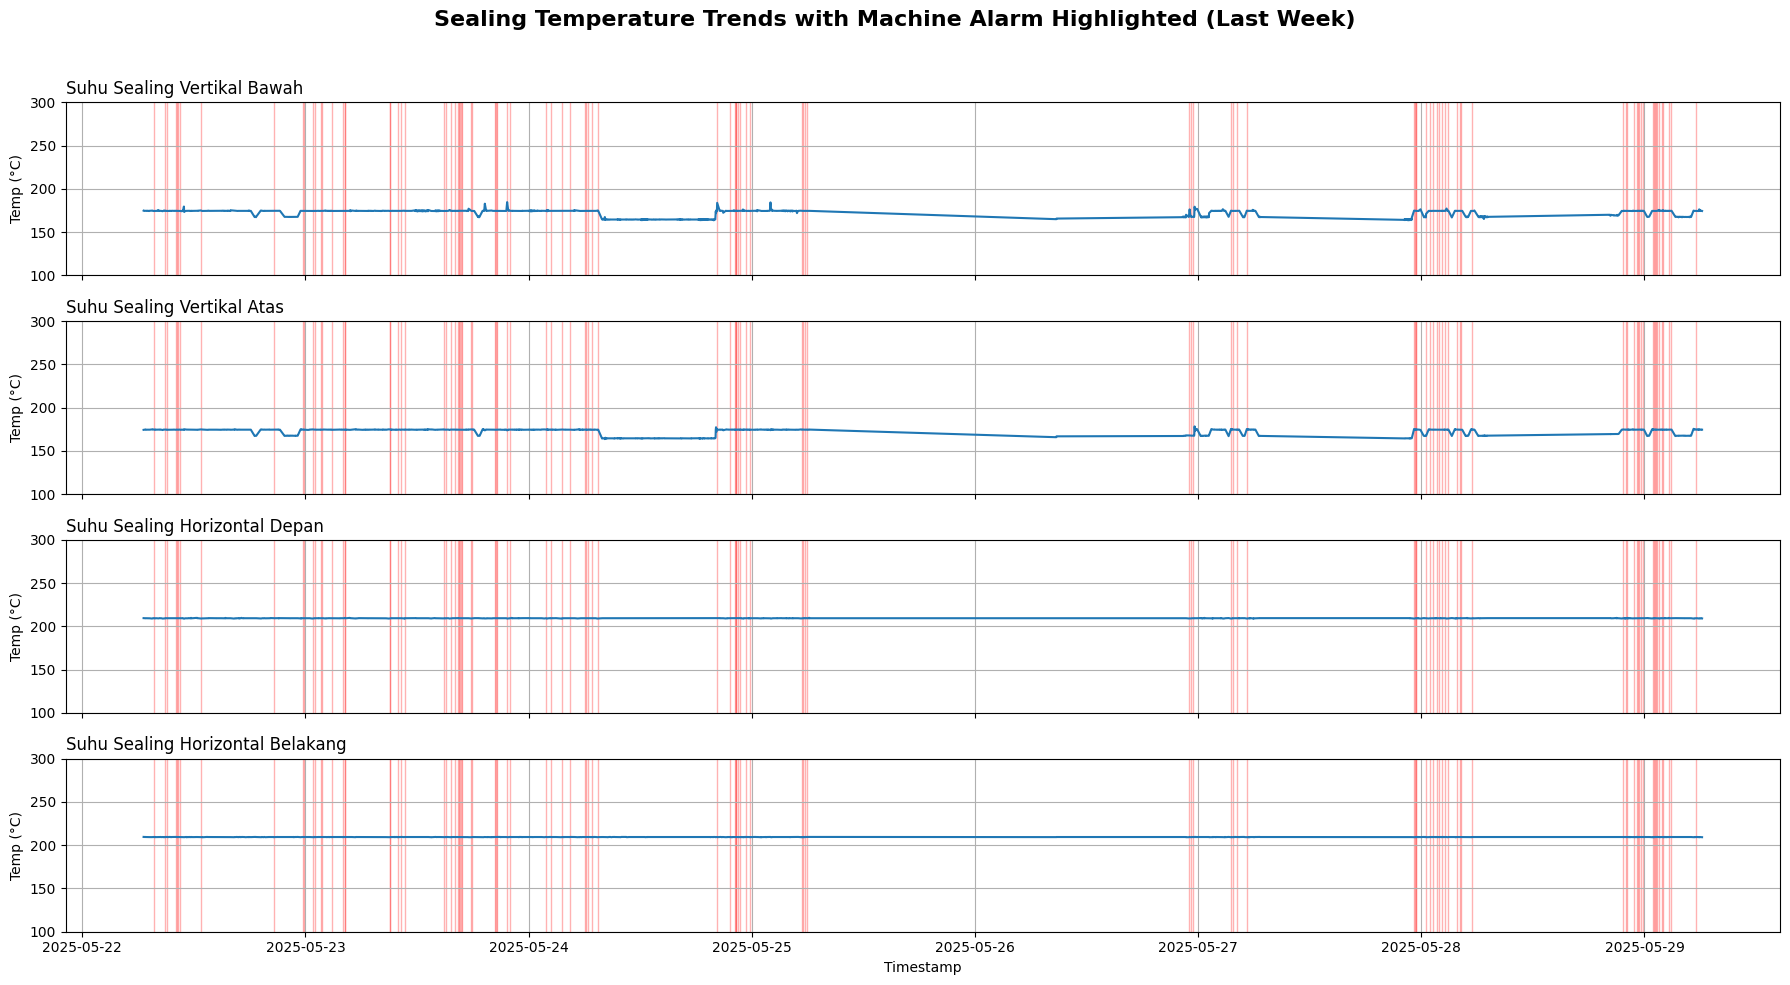

In [17]:
plot_temperature(df_cleaned, period="last_week", with_segments=True)

### Last Day

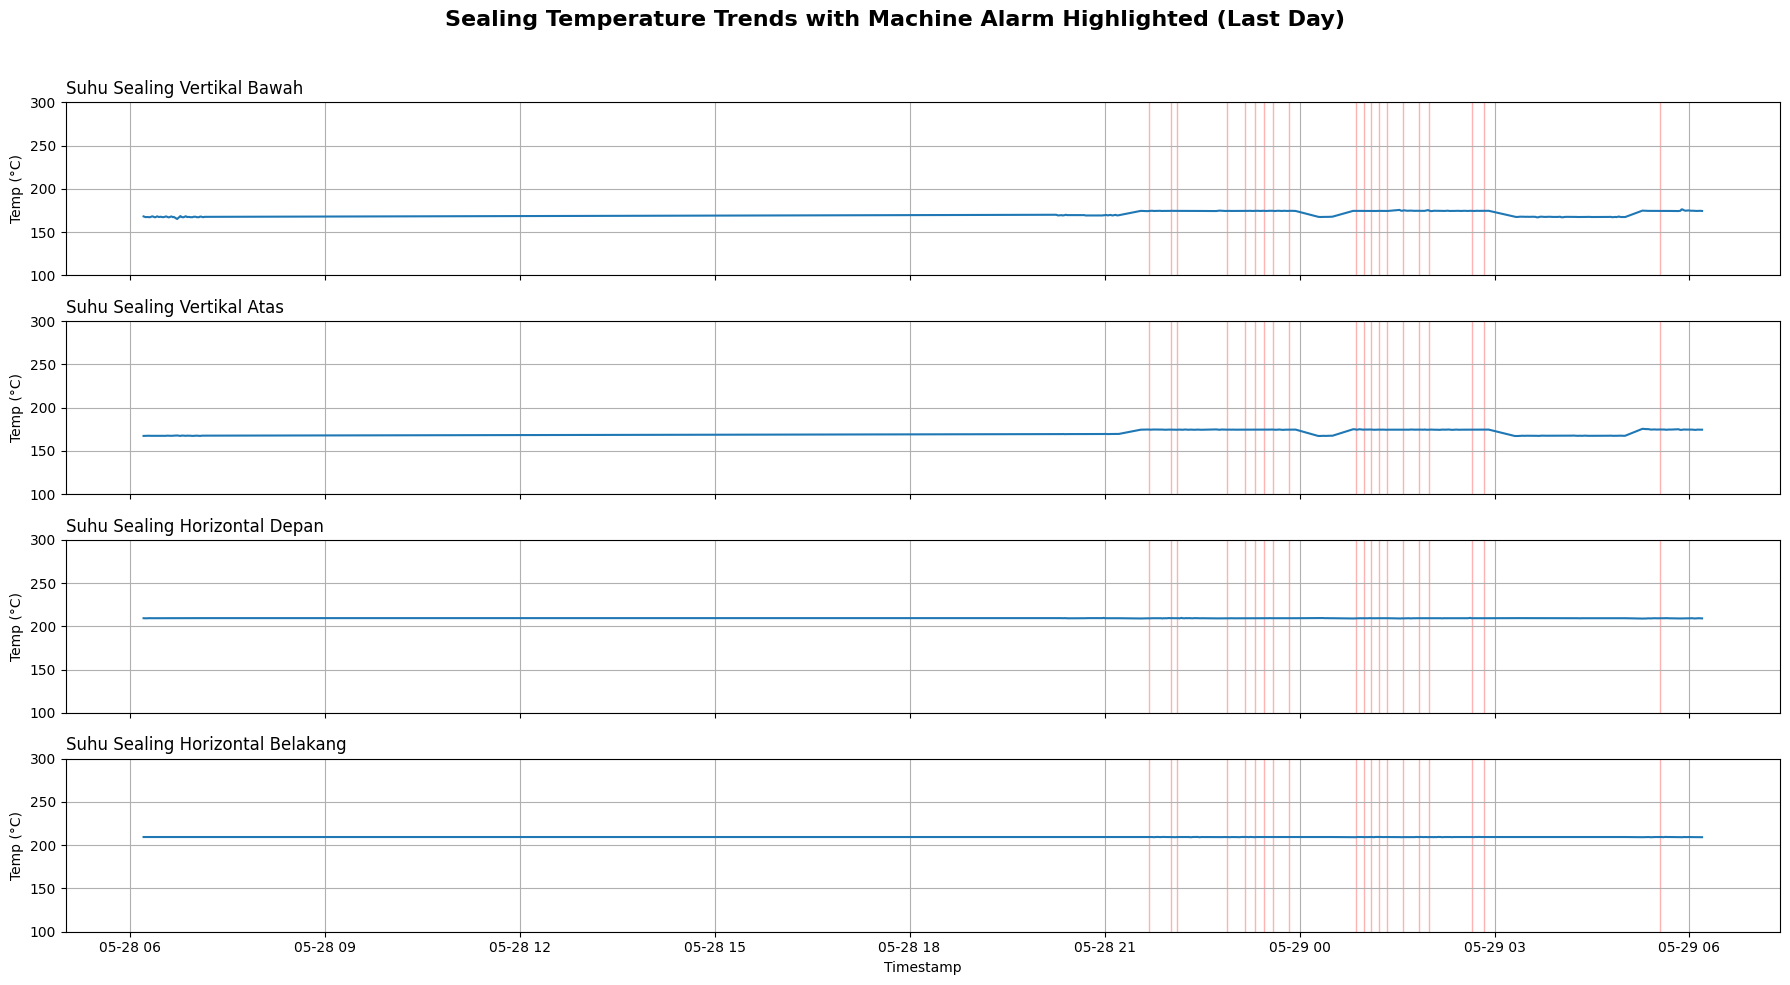

In [18]:
plot_temperature(df_cleaned, period="last_day", with_segments=True)

# II. Features Selection


**Tujuan:**

Menyiapkan data yang merepresentasikan kondisi normal mesin (tanpa alarm) sebagai dasar (baseline) untuk analisis lebih lanjut, seperti deteksi anomali atau pemodelan prediktif.

**Proses:**

Penyaringan Data Normal:
Dataset disaring untuk hanya menyertakan baris-baris data saat:

`machine_alarm == 0` → mesin tidak mengalami gangguan atau kondisi abnormal.

**Visualisasi:**

Sinyal suhu dari data normal divisualisasikan untuk periode satu hari terakhir, guna memastikan kestabilan dan konsistensi suhu selama kondisi mesin normal.

**Penghapusan Fitur yang Tidak Informatif:**

Fitur-fitur berikut dihapus karena selalu bernilai 0 dan tidak memberikan kontribusi informasi dalam analisis:

- jaws_position
- knife_position
- pump_position_stop

**Hasil Akhir:**

Dataset hasil seleksi disimpan sebagai datalog_ilapak10_normal.csv. Dataset ini akan digunakan sebagai acuan kondisi normal untuk membandingkan perilaku sistem saat terjadi anomali atau alarm.

In [19]:
df.head(1)

,suhu_sealing_vertikal_bawah,suhu_sealing_vertikal_atas,suhu_sealing_horizontal_depan,suhu_sealing_horizontal_belakang,jaws_position,knife_position,pump_position_stop,doser_drive_enable,sealing_enable,machine_alarm,downtime_sec,output_time_sec,total_time_sec
times,,,,,,,,,,,,,
2024-01-30 15:52:04,104.2,104.3,41.6,108.5,0,0,0,0,0,0,176.0,0.0,177.0


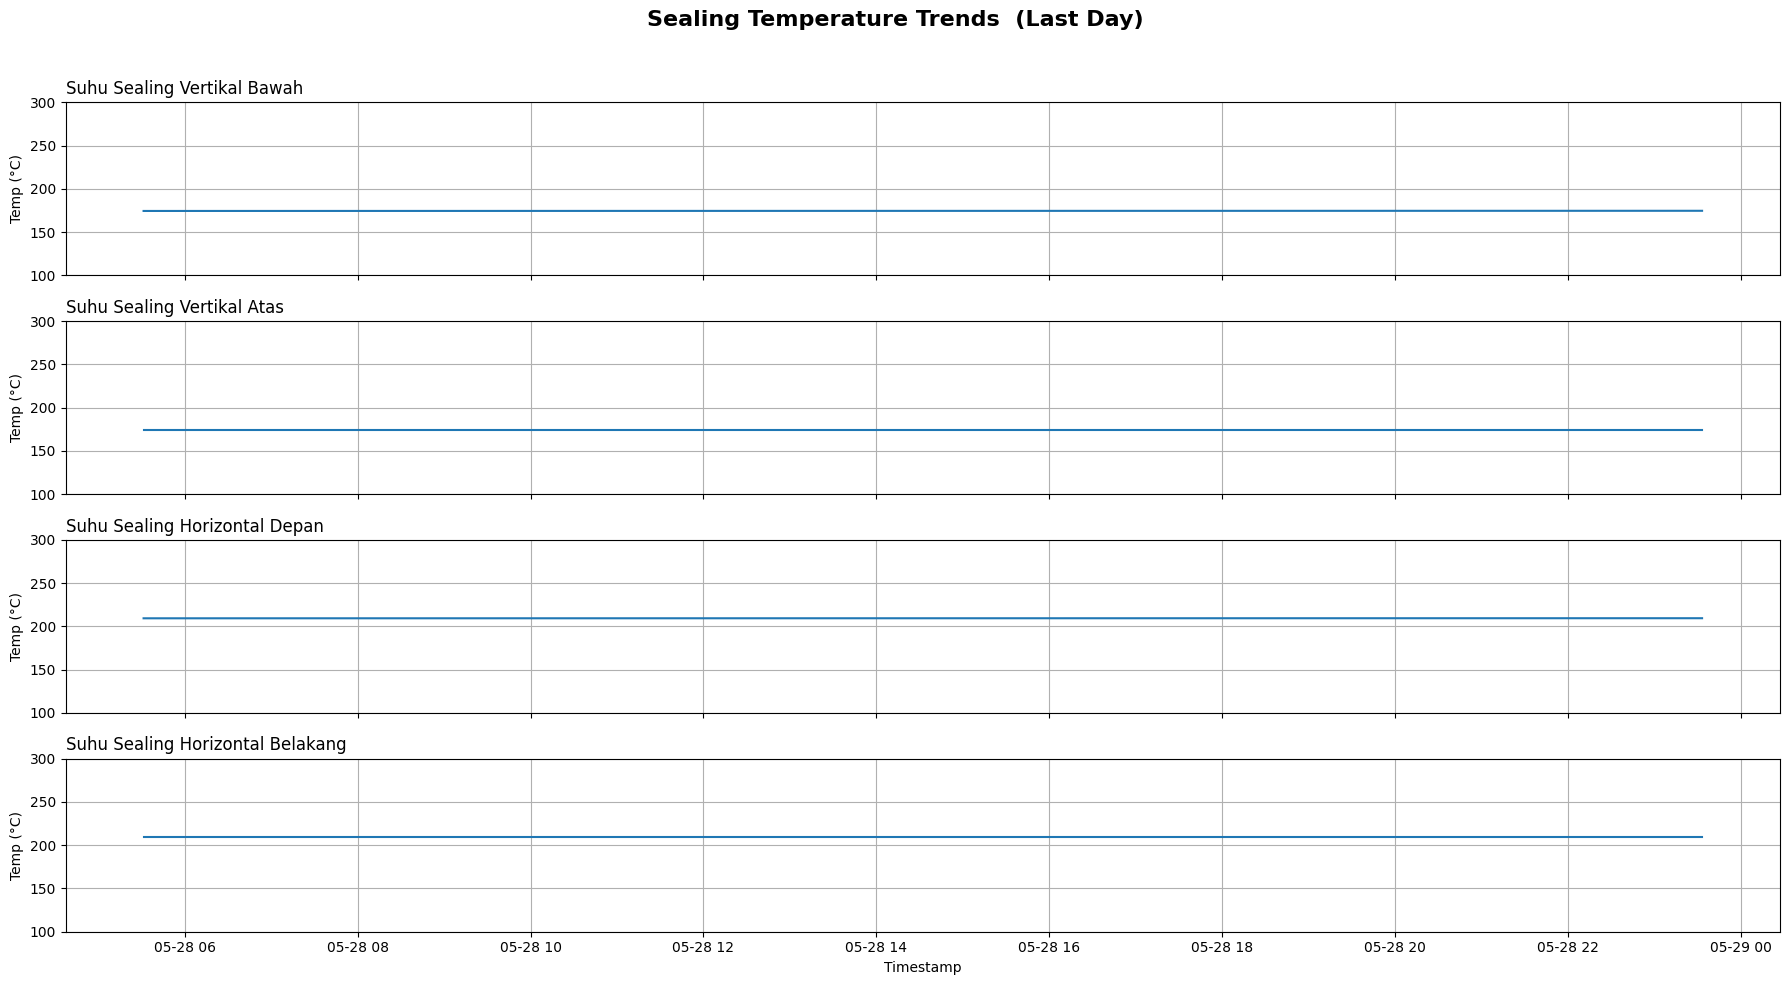

,suhu_sealing_vertikal_bawah,suhu_sealing_vertikal_atas,suhu_sealing_horizontal_depan,suhu_sealing_horizontal_belakang,output_time_sec
times,,,,,
2024-04-17 10:46:15,209.4,174.5,174.5,209.3,7233.0
2024-04-17 10:52:15,209.5,174.5,174.4,209.4,7206.0
2024-04-17 10:53:15,209.5,174.3,174.4,209.5,7205.0
2024-04-17 11:01:15,209.5,174.5,174.4,209.5,7203.0
2024-04-17 11:12:42,209.7,174.8,174.5,209.6,7214.0


In [20]:
data_normal = df_cleaned[(df_cleaned["machine_alarm"] == 0) & (df_cleaned["sealing_enable"] == 1) & (df_cleaned["doser_drive_enable"] == 1)]
plot_temperature(data_normal, period="last_day")

features_selected = [
    "suhu_sealing_vertikal_bawah", "suhu_sealing_vertikal_atas",
    "suhu_sealing_horizontal_depan", "suhu_sealing_horizontal_belakang",
    "output_time_sec",
]

# Drop that features because they are not useful (just 0)
df_final = data_normal[features_selected]
df_final.head()

In [21]:
df_final.describe()

,suhu_sealing_vertikal_bawah,suhu_sealing_vertikal_atas,suhu_sealing_horizontal_depan,suhu_sealing_horizontal_belakang,output_time_sec
count,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000
mean,194.663632,167.810444,182.596686,209.467213,7991.060921
std,20.458312,9.881548,21.782515,0.084571,7809.732062
min,147.900000,148.800000,148.800000,209.300000,0.000000
25%,174.500000,159.500000,162.100000,209.400000,0.000000
50%,209.400000,174.400000,174.600000,209.500000,6165.000000
75%,209.500000,174.600000,209.400000,209.500000,14400.500000
max,210.100000,190.600000,210.000000,209.600000,32762.000000


In [34]:
df_final_train = df_final[:int(len(df_final) * 0.9)]
df_final_test = df_final[int(len(df_final) * 0.9):]

In [36]:
df_final_test.to_csv("ilapak10_test.csv")
df_final_train.to_csv("ilapak10_train.csv")